In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
from shapely import wkt
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re
from scipy.optimize import curve_fit
import random
from collections import defaultdict, deque
import math
from mesa import Model, Agent
from mesa.datacollection import DataCollector
from public_transport_csv_script import remap_ids
from mesa.space import NetworkGrid
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
cities = pd.read_csv("data/cities.csv")
lines = pd.read_csv("data/lines.csv")
section_lines = pd.read_csv("data/section_lines.csv")
sections = pd.read_csv("data/sections.csv")
stations = pd.read_csv("data/stations.csv")
station_lines = pd.read_csv("data/station_lines.csv")
transport_modes = pd.read_csv("data/transport_modes.csv")

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)

In [4]:
stations_r = stations.rename(columns={"id": "station_id"})
lines_r    = lines.rename(columns={"id": "line_id"})
modes_r    = transport_modes.rename(columns={"id": "transport_mode_id",
                                           "name": "mode"})
cities_r   = cities.rename(columns={"id": "city_id", "name": "city"})

df_geom = (
    station_lines[["station_id", "line_id", "city_id"]]
      .merge(stations_r[["station_id", "city_id", "name", "geometry", "opening"]],
             on=["station_id", "city_id"], how="inner")
      .merge(lines_r[["line_id", "city_id", "transport_mode_id"]],
             on=["line_id", "city_id"], how="inner")
      .merge(modes_r[["transport_mode_id", "mode"]],
             on="transport_mode_id", how="left")
      .merge(cities_r[["city_id", "city"]], on="city_id", how="left")
      [["station_id", "name", "geometry", "mode", "opening", "city"]]
      .drop_duplicates()
      .sort_values(["city", "station_id"])
      .reset_index(drop=True)
)
df_geom = df_geom[["city", "station_id", "name", "geometry", "mode", "opening"]]


In [5]:
stations_r = stations_r.copy()
mask = stations_r["geometry"].notna()
stations_r["geometry"] = stations_r["geometry"].astype("object")
stations_r.loc[mask, "geometry"] = stations_r.loc[mask, "geometry"].apply(
    lambda g: wkt.loads(g) if isinstance(g, str) else g
)

gdf_stations = gpd.GeoDataFrame(stations_r, geometry="geometry", crs="EPSG:4326")

In [6]:
print(stations_r["geometry"].dtype)
print(stations_r["geometry"].head(3))


object
0    POINT (140.02481219712917 35.683774478472316)
1                     POINT (5.3801556 43.3024646)
2      POINT (140.0421467251747 35.67260211599806)
Name: geometry, dtype: object


In [7]:
m = df_geom["geometry"].str.extract(
    r'POINT\s*\(\s*(?P<lon>-?\d+(?:\.\d+)?)\s+(?P<lat>-?\d+(?:\.\d+)?)\s*\)',
    flags=re.I
)

df_geom["latitude"]  = pd.to_numeric(m["lat"], errors="coerce")
df_geom["longitude"] = pd.to_numeric(m["lon"], errors="coerce")

In [8]:
df = (
    df_geom.rename(columns={"station_id": "nodeID",
                       "name": "nodeLabel",
                       "opening": "year"})
      [["city", "nodeID", "nodeLabel", "latitude", "longitude", "mode", "year"]]
)

In [9]:
display(df.head(5))

,city,nodeID,nodeLabel,latitude,longitude,mode,year
0,Adana,32076,Huzurevi,37.040875,35.284417,heavy_rail,2010.0
1,Adana,32077,Yurt,37.026993,35.296414,heavy_rail,2010.0
2,Adana,32078,Yeşilyurt,37.020334,35.302510,heavy_rail,2010.0
3,Adana,32079,Mavi Bulvar,37.035574,35.287786,heavy_rail,2010.0
4,Adana,32080,Anadolu Lisesi,37.047753,35.280058,heavy_rail,2010.0


In [10]:
buc = df[df['city'] == 'Tokyo'].reset_index(drop=True)
display(buc.head(5))

,city,nodeID,nodeLabel,latitude,longitude,mode,year
0,Tokyo,3680,稲荷町 Inaricho,35.711339,139.782569,heavy_rail,1927.0
1,Tokyo,3681,田原町 Tawaramachi,35.709859,139.790465,heavy_rail,1927.0
2,Tokyo,3682,浅草 Asakusa,35.710768,139.797755,heavy_rail,1927.0
3,Tokyo,3683,上野 Ueno,35.711705,139.776147,heavy_rail,1927.0
4,Tokyo,3684,末広町 Suehirocho,35.702936,139.771677,heavy_rail,1930.0


In [11]:
buc = buc.merge(
    station_lines[["station_id", "line_id"]],
    how="left",
    left_on="nodeID",
    right_on="station_id"
).drop(columns="station_id")

In [12]:
def _haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1, lon1, lat2, lon2 = map(np.deg2rad, (lat1, lon1, lat2, lon2))
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def build_edges_mst(
    df_line,
    min_stations_for_loop=5,
    min_radius_km=0.5,
    max_radius_coeff_var=0.35,
    min_perim_diam_ratio=1.8,
):

    g = df_line.dropna(subset=["latitude", "longitude"]).copy()
    if len(g) < 2:
        return pd.DataFrame(
            columns=["nodeID_from", "nodeID_to", "line_id", "mode", "year", "dist_km"]
        )

    line_id = g["line_id"].iloc[0]

    lats = g["latitude"].to_numpy()
    lons = g["longitude"].to_numpy()
    ids  = g["nodeID"].astype(int).to_numpy()

    H = nx.Graph()
    for nid, lat, lon, mode, year in zip(
        ids, lats, lons, g["mode"], g["year"]
    ):
        H.add_node(
            int(nid),
            lat=float(lat),
            lon=float(lon),
            mode=mode,
            year=year
        )

    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            a, b = int(ids[i]), int(ids[j])
            ra = H.nodes[a]
            rb = H.nodes[b]
            w = _haversine_km(ra["lat"], ra["lon"], rb["lat"], rb["lon"])
            H.add_edge(a, b, weight=w)

    T = nx.minimum_spanning_tree(H, weight="weight")

    center_lat = float(lats.mean())
    center_lon = float(lons.mean())

    radii = np.array([
        _haversine_km(lat, lon, center_lat, center_lon)
        for lat, lon in zip(lats, lons)
    ])
    r_mean = float(radii.mean())
    r_std  = float(radii.std(ddof=0))

    n = len(ids)
    max_dist = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            d = _haversine_km(lats[i], lons[i], lats[j], lons[j])
            if d > max_dist:
                max_dist = d
    diameter_km = max_dist

    perimeter_mst_km = float(sum(d["weight"] for _, _, d in T.edges(data=True)))

    is_loop = False
    if (
        len(g) >= min_stations_for_loop and
        diameter_km > 0 and
        r_mean > 0
    ):
        radius_coeff_var  = r_std / r_mean
        perim_diam_ratio  = perimeter_mst_km / diameter_km

        if (
            r_mean >= min_radius_km and
            radius_coeff_var <= max_radius_coeff_var and
            perim_diam_ratio >= min_perim_diam_ratio
        ):
            is_loop = True

    if is_loop:
        degrees = dict(T.degree())
        leaves = [n for n, d in degrees.items() if d == 1]

        if len(leaves) >= 2:
            best_pair = None
            best_w = float("inf")
            for i in range(len(leaves)):
                for j in range(i + 1, len(leaves)):
                    u = leaves[i]
                    v = leaves[j]
                    ru = H.nodes[u]
                    rv = H.nodes[v]
                    w = _haversine_km(ru["lat"], ru["lon"], rv["lat"], rv["lon"])
                    if w < best_w:
                        best_w = w
                        best_pair = (u, v)

            if best_pair is not None:
                u, v = best_pair
                T.add_edge(u, v, weight=best_w)

    edges = []
    for a, b, d in T.edges(data=True):
        na = H.nodes[a]
        edges.append(
            (int(a), int(b), line_id, na["mode"], na["year"], float(d["weight"]))
        )

    edges_df = pd.DataFrame(
        edges,
        columns=["nodeID_from", "nodeID_to", "line_id", "mode", "year", "dist_km"]
    ).drop_duplicates()

    return edges_df


In [13]:
def make_graph(df_nodes, edges):
    G = nx.Graph()
    for _, r in df_nodes.iterrows():
        G.add_node(
            int(r.nodeID),
            label=r.nodeLabel,
            pos=(float(r.longitude), float(r.latitude)),
            mode = r['mode']
        )
    for _, e in edges.iterrows():
        G.add_edge(
            int(e.nodeID_from),
            int(e.nodeID_to),
            line_id=e.line_id,
            dist_km=e.dist_km,
            mode = e['mode']
        )

    return G

In [14]:
graphs_by_line = {}
G_all = nx.Graph()
edges_all = pd.DataFrame(columns=["nodeID_from","nodeID_to","line_id","mode","year"])
center_lat = buc['latitude'].mean()
center_lon = buc['longitude'].mean()

for line_id, grp in buc.groupby("line_id", dropna=False):
    edges = build_edges_mst(grp)
    G_line = make_graph(grp, edges)
    G_all = nx.compose(G_all, G_line)
    edges_all = pd.concat([edges_all, edges], ignore_index=True)

modes = nx.get_edge_attributes(G_all, "mode").values()
unique_modes = set(modes)
print(unique_modes)
print("Number of unique modes:", len(unique_modes))

{'tram', 'light_rail', 'heavy_rail', 'people_mover', 'high_speed_rail', 'commuter_rail', 'default'}
Number of unique modes: 7


/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_20317/1800342790.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(line_ids))


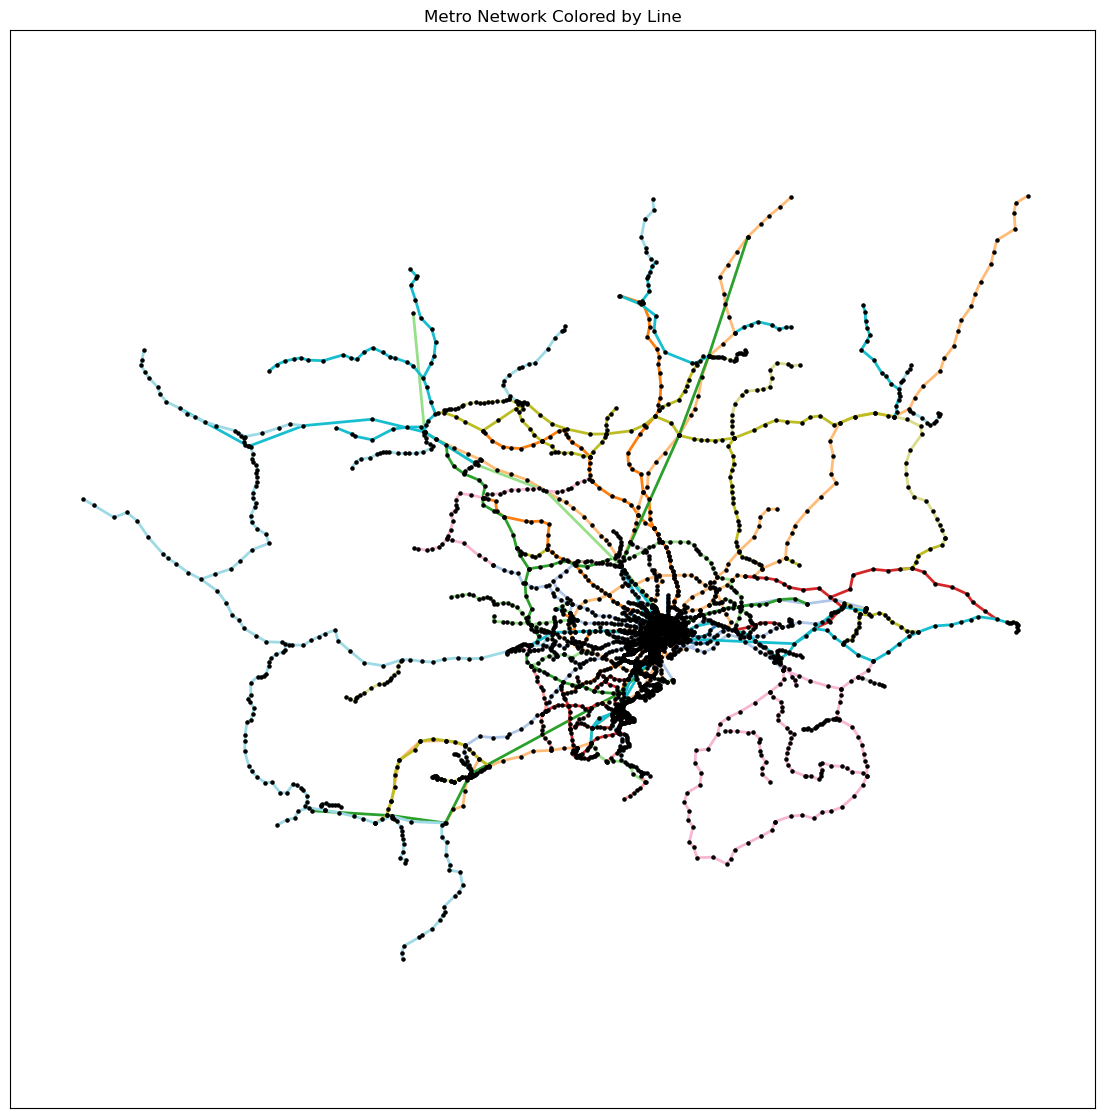

In [15]:
line_ids = sorted({d["line_id"] for _,_,d in G_all.edges(data=True)})
cmap = cm.get_cmap('tab20', len(line_ids))
line_to_color = {line_id: cmap(i) for i, line_id in enumerate(line_ids)}


plt.figure(figsize=(14,14))
pos = {n: G_all.nodes[n]["pos"] for n in G_all.nodes}
nx.draw_networkx_nodes(
    G_all, pos,
    node_size=5,
    node_color="black",
)

for line_id in line_ids:
    edges_of_line = [
        (u, v) for u, v, d in G_all.edges(data=True)
        if d["line_id"] == line_id
    ]

    nx.draw_networkx_edges(
        G_all, pos,
        edgelist=edges_of_line,
        width=2,
        edge_color=[line_to_color[line_id]],
        
    )
    #n#x.draw_networkx_labels(
     #   G_all, pos,
       # font_size=8,
       # font_color='black'
    #)
plt.axis("equal")
plt.title("Metro Network Colored by Line")
plt.show()

In [16]:
buc[buc['nodeID'] == 16218]

,city,nodeID,nodeLabel,latitude,longitude,mode,year,line_id


In [17]:
buc[buc['nodeID'] == 37547]

,city,nodeID,nodeLabel,latitude,longitude,mode,year,line_id


In [18]:
G_all.get_edge_data(37547, 16218)

In [19]:
df[df['nodeID'] == 16218]

,city,nodeID,nodeLabel,latitude,longitude,mode,year
11990,London,16218,Pirbright,51.302579,-0.654379,inter_city_rail,1838.0


In [20]:
station_lines[(station_lines['line_id'] == 144) & ((station_lines['station_id'] == 16218) | (station_lines['station_id'] == 37547))]

,id,station_id,line_id,city_id,created_at,updated_at,fromyear,toyear,deprecated_line_group
7493,44848,37547,144,69,2024-04-29 22:05:36.955131,2024-04-29 22:05:36.955131,NaN,NaN,0
14935,16548,16218,144,69,2019-02-14 23:17:00.720722,2019-02-14 23:17:00.720722,NaN,NaN,0


In [21]:
def merge_graph(G, max_dist_km=0.7):
    
    def get_label(n):
        d = G.nodes[n]
        return d.get("nodeLabel") or d.get("label") or d.get("name") or str(n)

    def get_lonlat(n):
        d = G.nodes[n]
        if "pos" in d:
            lon, lat = d["pos"]
        else:
            lon, lat = d["longitude"], d["latitude"]
        return float(lon), float(lat)

    label_to_nodes = {}
    for n in G.nodes:
        lbl = get_label(n)
        label_to_nodes.setdefault(lbl, []).append(n)

    H = nx.Graph()
    old_to_new = {}

    for label, nodes in label_to_nodes.items():
        if len(nodes) == 1:
            n = nodes[0]
            new_name = label 

            attrs = G.nodes[n].copy()
            attrs["label"] = label
            lon, lat = get_lonlat(n)
            attrs["pos"] = (lon, lat)
            attrs["orig_nodes"] = [n]

            H.add_node(new_name, **attrs)
            old_to_new[n] = new_name
            continue

        
        C = nx.Graph()
        for n in nodes:
            C.add_node(n)

       
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                a, b = nodes[i], nodes[j]
                lon1, lat1 = get_lonlat(a)
                lon2, lat2 = get_lonlat(b)
                d = _haversine_km(lat1, lon1, lat2, lon2)
                if d <= max_dist_km:
                    C.add_edge(a, b, dist_km=d)

        components = list(nx.connected_components(C))

        for idx, comp in enumerate(components):
            comp = list(comp)

            if len(components) == 1:
                new_name = label
            else:
                new_name = f"{label} ({idx+1})"

            lons = []
            lats = []
            modes = set()
            years = []

            for n in comp:
                lon, lat = get_lonlat(n)
                lons.append(lon)
                lats.append(lat)
                d = G.nodes[n]
                if "mode" in d:
                    modes.add(d["mode"])
                if "year" in d and d["year"] is not None:
                    years.append(d["year"])

            lon_avg = float(np.mean(lons))
            lat_avg = float(np.mean(lats))

            attrs = {}
            attrs.update(G.nodes[comp[0]])
            attrs["label"] = label
            attrs["pos"] = (lon_avg, lat_avg)
            attrs["lon"] = lon_avg
            attrs["lat"] = lat_avg
            attrs["modes"] = list(modes) if modes else None
            attrs["year_min"] = min(years) if years else None
            attrs["orig_nodes"] = comp

            H.add_node(new_name, **attrs)

            for n in comp:
                old_to_new[n] = new_name

    for u, v, data in G.edges(data=True):
        u_new = old_to_new.get(u)
        v_new = old_to_new.get(v)
        if u_new is None or v_new is None:
            continue
        if u_new == v_new:
            continue

        if H.has_edge(u_new, v_new):
            if "line_id" in data:
                existing = H[u_new][v_new].get("line_ids", set())
                existing.add(data["line_id"])
                H[u_new][v_new]["line_ids"] = existing
        else:
            H.add_edge(u_new, v_new, **data)

    return H



In [22]:
G_all = nx.Graph()
for line_id, grp in buc.groupby("line_id", dropna=False):
    edges_line = build_edges_mst(grp)   
    G_line = make_graph(grp, edges_line)
    G_all = nx.compose(G_all, G_line)

G_all = merge_graph(G_all)  
modes = nx.get_edge_attributes(G_all, "mode").values()
unique_modes = set(modes)
print(unique_modes)
print("Number of unique modes:", len(unique_modes))


{'tram', 'light_rail', 'heavy_rail', 'people_mover', 'high_speed_rail', 'commuter_rail', 'default'}
Number of unique modes: 7


/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_20317/657165552.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(line_ids))


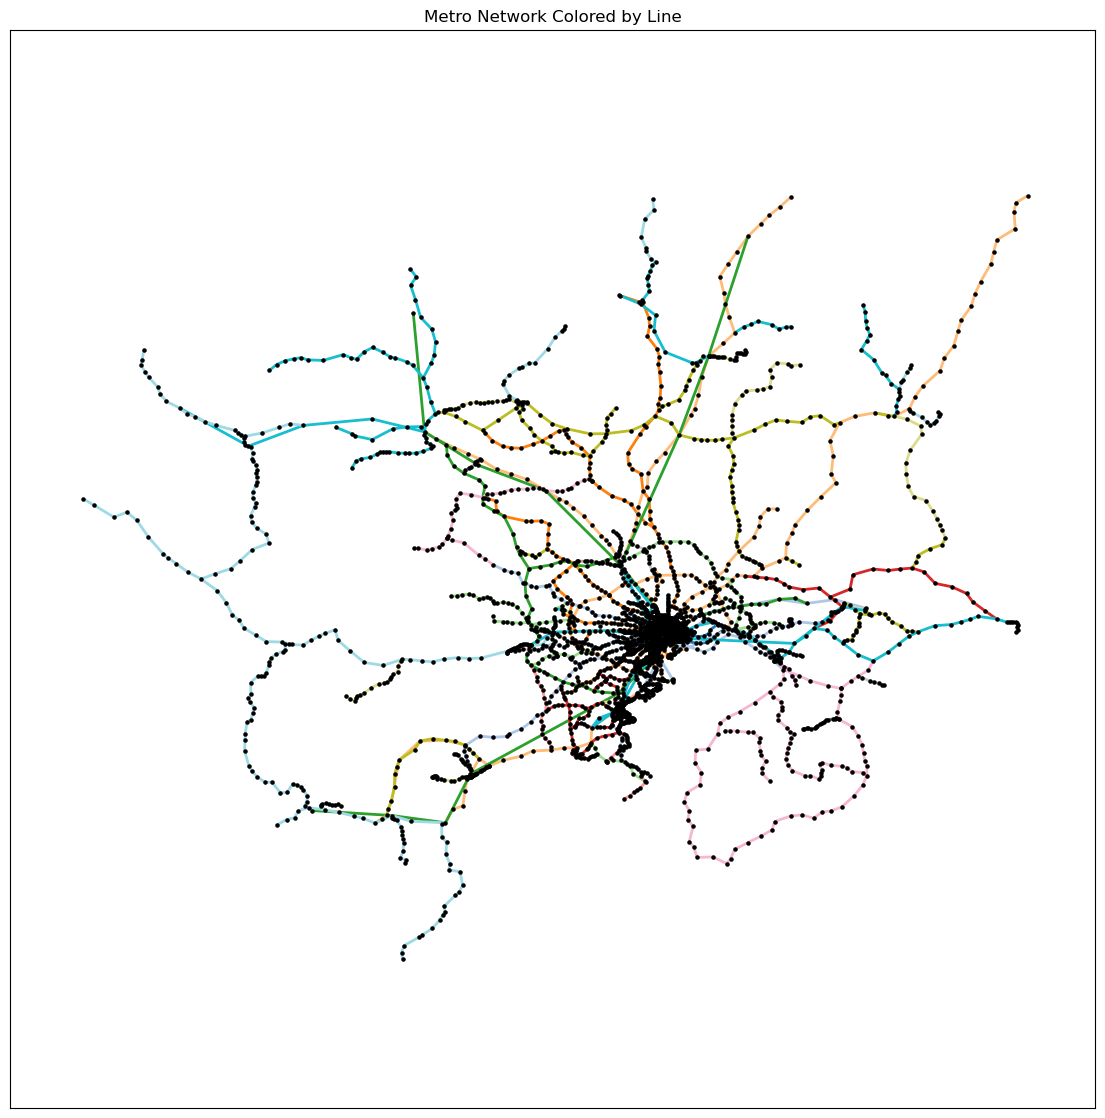

In [23]:
line_ids = sorted({d["line_id"] for _,_,d in G_all.edges(data=True)})
cmap = cm.get_cmap('tab20', len(line_ids))
line_to_color = {line_id: cmap(i) for i, line_id in enumerate(line_ids)}


plt.figure(figsize=(14,14))
pos = {n: G_all.nodes[n]["pos"] for n in G_all.nodes}
nx.draw_networkx_nodes(
    G_all, pos,
    node_size=5,
    node_color="black",
)

for line_id in line_ids:
    edges_of_line = [
        (u, v) for u, v, d in G_all.edges(data=True)
        if d["line_id"] == line_id
    ]

    nx.draw_networkx_edges(
        G_all, pos,
        edgelist=edges_of_line,
        width=2,
        edge_color=[line_to_color[line_id]],
        
    )
    #nx.draw_networkx_labels(
        #G_all, pos,
        #font_size=8,
        #font_color='black',
    #)

plt.axis("equal")
plt.title("Metro Network Colored by Line")
plt.show()



In [24]:
G_all.adj

AdjacencyView({'稲荷町 Inaricho': {'上野 Ueno': {'line_id': 324, 'dist_km': 0.58122605030067, 'mode': 'heavy_rail'}, '田原町 Tawaramachi': {'line_id': 324, 'dist_km': 0.7316901561696695, 'mode': 'heavy_rail'}, 'Shitayajinjamae': {'line_id': 828, 'dist_km': 0.10372219683062127, 'mode': 'light_rail'}, 'Matsugaya-itchome': {'line_id': 828, 'dist_km': 0.17562824836139918, 'mode': 'light_rail'}}, '田原町 Tawaramachi': {'稲荷町 Inaricho': {'line_id': 324, 'dist_km': 0.7316901561696695, 'mode': 'heavy_rail'}, '浅草 Asakusa': {'line_id': 324, 'dist_km': 0.6658930421347228, 'mode': 'heavy_rail'}}, '浅草 Asakusa': {'田原町 Tawaramachi': {'line_id': 324, 'dist_km': 0.6658930421347228, 'mode': 'heavy_rail'}, '本所吾妻橋 Honjo-Azumabashi': {'line_id': 333, 'dist_km': 0.7194761962208415, 'mode': 'heavy_rail'}, '蔵前 Kuramae': {'line_id': 333, 'dist_km': 0.7973502642696846, 'mode': 'heavy_rail'}, 'Kaminarimon': {'line_id': 828, 'dist_km': 0.12471099495589984, 'mode': 'light_rail'}, 'Azumabashi-itchome': {'line_id': 828, 'dist_k

In [25]:
G_all = nx.Graph()
for line_id, grp in buc.groupby("line_id", dropna=False):
    edges_line = build_edges_mst(grp)   
    G_line = make_graph(grp, edges_line)
    G_all = nx.compose(G_all, G_line)

G_all = merge_graph(G_all)  
modes = nx.get_edge_attributes(G_all, "mode").values()
unique_modes = set(modes)
print(unique_modes)
print("Number of unique modes:", len(unique_modes))

{'tram', 'light_rail', 'heavy_rail', 'people_mover', 'high_speed_rail', 'commuter_rail', 'default'}
Number of unique modes: 7


In [26]:
largest_cc_nodes = max(nx.connected_components(G_all), key=len)
G_connect = G_all.subgraph(largest_cc_nodes).copy()

In [27]:
destination_nodes = {'浅草 Asakusa':10,
                    '押上 Oshiage (Skytree)':10,
                    '本所吾妻橋 Honjo-Azumabashi':7, 
                    '蔵前 Kuramae':7,
                    '田原町 Tawaramachi':4,
                    '上野 Ueno':4, 
                    'Okachimachi':3,
                    '両国 Ryogoku':3, 
                    '浅草橋 Asakusabashi':3,
                    '南千住 Minami-Senju':2}
destination_nodes_names = list(destination_nodes.keys())

In [28]:
G_all.nodes["南千住 Minami-Senju"]

{'label': '南千住 Minami-Senju',
 'pos': (139.7989505301043, 35.73288235983307),
 'mode': 'heavy_rail',
 'lon': 139.7989505301043,
 'lat': 35.73288235983307,
 'modes': ['heavy_rail'],
 'year_min': None,
 'orig_nodes': [3801, 5406, 6103]}

In [29]:
destination_nodes_names

['浅草 Asakusa',
 '押上 Oshiage (Skytree)',
 '本所吾妻橋 Honjo-Azumabashi',
 '蔵前 Kuramae',
 '田原町 Tawaramachi',
 '上野 Ueno',
 'Okachimachi',
 '両国 Ryogoku',
 '浅草橋 Asakusabashi',
 '南千住 Minami-Senju']

In [30]:
dest_names = np.array(list(destination_nodes.keys()))
w = np.array([destination_nodes[k] for k in dest_names], dtype=float)
dest_prob = w / w.sum()

In [31]:
dest_prob.sum()

np.float64(1.0)

In [32]:
rng = np.random.default_rng(42)
nodes = np.array(list(G_connect.nodes))
origins = rng.choice(nodes, size=2000)
origin_share = np.ones(len(origins)) / len(origins)   

In [33]:
sum(origin_share)

np.float64(0.9999999999999453)

In [34]:
time_bins  = ["14:00","15:00","16:00","17:00","18:00","19:00"]
time_share = np.array([0.05, 0.10, 0.20, 0.30, 0.25, 0.10], dtype=float)
time_share = time_share / time_share.sum()

In [35]:
# Synthetic arrival distribution based on sensible guesses
def assign_timebins(G,
                    origins,
                    dest_nodes,
                    dest_prob,
                    total_people,
                    time_bins,
                    time_share, #fractions of people arriving by each time bin
                    weight='dist_km'):
    origins = list(origins)
    K = len(origins)
    origin_share = np.ones(K) / K #origin shares quantize what fraction of total people start at each origin
    origin_share = origin_share / origin_share.sum()
    arrivals = {t: defaultdict(float) for t in time_bins} #number of people that arrived at their destination by time t
    origin_paths = {}
    for o in origins:
        _, paths = nx.single_source_dijkstra(G, o, weight=weight)
        origin_paths[o] = paths
    for t, s in zip(time_bins, time_share):
        bin_people = total_people * float(s) #number of people arriving in this time bin
        for o, os in zip(origins, origin_share):
            paths = origin_paths[o]
            for d, dp in zip(dest_nodes, dest_prob):
                f = bin_people * os * dp #number of people from origin o to destination d in this time bin
                arrivals[t][d] += f 
                path = paths.get(d)
                if not path:
                    continue
    return arrivals

arrivals = assign_timebins(G_connect, origins, dest_names, dest_prob, total_people=900_000, time_bins=time_bins, time_share=time_share)

In [36]:
def arrival_schedule_from_bins(arrivals, hotspot, time_bins, tick_seconds=180, bin_seconds=3600):
    ticks_per_bin = int(bin_seconds // tick_seconds)
    sched = {}
    tick0 = 0
    for tb in time_bins:
        people_in_bin = float(arrivals[tb].get(hotspot, 0.0))
        per_tick = people_in_bin / ticks_per_bin
        for k in range(ticks_per_bin):
            sched[tick0 + k] = per_tick 
        tick0 += ticks_per_bin
    return sched
asakusa_schedule = arrival_schedule_from_bins(arrivals, "浅草 Asakusa", time_bins)
oshiage_schedule = arrival_schedule_from_bins(arrivals, "押上 Oshiage (Skytree)", time_bins)
honjo_schedule = arrival_schedule_from_bins(arrivals, "本所吾妻橋 Honjo-Azumabashi", time_bins)
kuramae_schedule = arrival_schedule_from_bins(arrivals, "蔵前 Kuramae", time_bins)
tawaramachi_schedule = arrival_schedule_from_bins(arrivals, "田原町 Tawaramachi", time_bins)
ueno_schedule = arrival_schedule_from_bins(arrivals, "上野 Ueno", time_bins)
oka_schedule = arrival_schedule_from_bins(arrivals, "Okachimachi", time_bins)
ryo_schedule = arrival_schedule_from_bins(arrivals, "両国 Ryogoku", time_bins)
asakusabashi_schedule = arrival_schedule_from_bins(arrivals, "浅草橋 Asakusabashi", time_bins)

In [37]:
schedules = {
    name: arrival_schedule_from_bins(arrivals, name, time_bins)
    for name in destination_nodes_names
}

In [38]:
schedules

{'浅草 Asakusa': {0: 424.52830188678644,
  1: 424.52830188678644,
  2: 424.52830188678644,
  3: 424.52830188678644,
  4: 424.52830188678644,
  5: 424.52830188678644,
  6: 424.52830188678644,
  7: 424.52830188678644,
  8: 424.52830188678644,
  9: 424.52830188678644,
  10: 424.52830188678644,
  11: 424.52830188678644,
  12: 424.52830188678644,
  13: 424.52830188678644,
  14: 424.52830188678644,
  15: 424.52830188678644,
  16: 424.52830188678644,
  17: 424.52830188678644,
  18: 424.52830188678644,
  19: 424.52830188678644,
  20: 849.0566037735729,
  21: 849.0566037735729,
  22: 849.0566037735729,
  23: 849.0566037735729,
  24: 849.0566037735729,
  25: 849.0566037735729,
  26: 849.0566037735729,
  27: 849.0566037735729,
  28: 849.0566037735729,
  29: 849.0566037735729,
  30: 849.0566037735729,
  31: 849.0566037735729,
  32: 849.0566037735729,
  33: 849.0566037735729,
  34: 849.0566037735729,
  35: 849.0566037735729,
  36: 849.0566037735729,
  37: 849.0566037735729,
  38: 849.0566037735729,
 

In [39]:
class Cohort:
    __slots__ = ("mass", "node", "dest") #attributes
    def __init__(self, mass, node, dest):
        self.mass = float(mass)
        self.node = node
        self.dest = dest

class QueueModel(Model):
    def __init__(self, 
                 H: nx.Graph,
                 entry_nodes,
                 dest_nodes,
                 schedules,
                 total_target,
                 pos,
                 sigma_xy,
                 center=None,
                 weight='dist_km',
                 tick_seconds=180,
                 cohort_mass=float(20),
                 cap_attr = 'cap_ppl_per_tick',
                 seed=1,
                 alpha=1,
                 beta=1,
                 eps=1e-6):
        super().__init__()
        self.rng = np.random.default_rng(seed)

        self.H = H.copy()

        self.alpha = float(alpha)
        self.beta = float(beta)
        self.eps = float(eps)

        self.pos = pos
        self.sigma_xy = sigma_xy
        self.center = np.asarray(center, dtype=float)
        
        
        self.node_queue_sum = defaultdict(float)
        self.edge_flow_sum =defaultdict(float)
        self.dest_nodes = list(dest_nodes)
        self.dest_set = set(self.dest_nodes)
        self.entry_nodes = list(entry_nodes)
        self.cohort_mass = float(cohort_mass)
        self.weight = weight
        self.cap_attr = cap_attr
        self.tick_seconds = tick_seconds
        self.running = True
        self.schedules = schedules   
        self.L_dest = self._procompute_entry_dest_lengths()
        self.entry_p = self._gaussian_entry_probs(self.sigma_xy)
        self.node_queue_max = defaultdict(float)
        self.line_nodes = defaultdict(set)
        for u, v, d in self.H.edges(data=True):
            lid = d.get("line_id")
            if lid is not None:
                self.line_nodes[lid].add(u)
                self.line_nodes[lid].add(v)

        self.tick = 0
        self.in_system = 0.0
        self.completed = 0.0
        self.injected = 0.0
        self.moved_to = 0.0
        self.injected_target = total_target

        self.waiting = {n: deque() for n in self.H.nodes}
        self.entry_split = {n: 1.0 / len(self.entry_nodes) for n in self.entry_nodes}

        

        self.next_hop = self._compute_next_hop()
        self.closest_dest_of_entry = self._closest_destination()
        def per_line_queue_mass(m):
            out = {}
            for lid, nodes in m.line_nodes.items():
                q = 0.0
                for n in nodes:
                    q += sum(c.mass for c in m.waiting[n])
                out[lid] = q
            return out

        self.datacollector = DataCollector(
        model_reporters={
            "tick": lambda m: m.tick,
            "in_system": lambda m: m.in_system,
            "completed": lambda m: m.completed,
            "total_queued": lambda m: sum(sum(c.mass for c in q) for q in m.waiting.values()),
            "max_node_queue": lambda m: max((sum(c.mass for c in q) for q in m.waiting.values()), default=0.0),
            "median_nonzero_queue": lambda m: (
                float(np.median([sum(c.mass for c in q) for q in m.waiting.values() if sum(c.mass for c in q) > 0]))
                if any(sum(c.mass for c in q) > 0 for q in m.waiting.values())
                else 0.0
            ),
            "global_max_node_queue": lambda m: max(m.node_queue_max.values(), default=0.0),
            "line_queue_mass": per_line_queue_mass
        }
    )



    def _find_center(self):
        xy = np.array([self.pos[n] for n in self.entry_nodes], dtype=float)
        return xy.mean(axis=0)
    
    def _gaussian_entry_probs(self, sigma_xy: float):
        xy = np.array([self.pos[n] for n in self.entry_nodes], dtype=float)
        r2 = np.sum((xy - self.center)**2, axis=1)
        w = np.exp(-0.5 * r2 / (sigma_xy**2))
        Z = w.sum()
        if not np.isfinite(Z) or Z <= 0:
            return np.ones(len(self.entry_nodes), dtype=float) / len(self.entry_nodes)
        return w / Z

    def dest_probs(self, e, tick, alpha=1.0, beta=1.0, eps=1e-6):
    # candidate destinations reachable from e
            Lmap = self.L_dest.get(e)
            
            dests = np.array(list(Lmap.keys()), dtype=object)
            L    = np.array([Lmap[d] for d in dests], dtype=float)

            lam  = np.array([float(self.schedules[d].get(tick, 0.0)) for d in dests], dtype=float)

            # score = alpha*log(lam+eps) - beta*L
            score = alpha * np.log(lam + eps) - beta * L

            # stable softmax
            score -= score.max()
            w = np.exp(score)
            Z = w.sum()
            if Z <= 0:
                return dests, np.ones_like(w) / len(w)
            p = w / Z
            return dests, p
    
    def lambda_d(self, d, tick):
        return float(self.schedules[d].get(tick))
    
    def _procompute_entry_dest_lengths(self):
        lengths = {}
        for e in self.entry_nodes:
            dist_map = nx.single_source_dijkstra_path_length(self.H, e, weight=self.weight)
            lengths[e] = {d: float(dist_map[d]) for d in self.dest_nodes if d in dist_map}
        return lengths

    def _closest_destination(self):
        closest = {}
        for e in self.entry_nodes:
            best_d = None
            best_L = float("inf")
            for d in self.dest_nodes:
                L = nx.shortest_path_length(self.H, e, d, weight=self.weight)
                if L < best_L:
                    best_L = L
                    best_d = d
                closest[e] = best_d
        return closest
    def _compute_next_hop(self):
        tables = {}
        for d in self.dest_nodes:
            nh = {}
            for u in self.H.nodes:
                if u == d:
                    nh[u] = None
                    continue
                p = nx.shortest_path(self.H, u, d, weight=self.weight)
                nh[u] = p[1]
            tables[d] = nh
        return tables 
    
    
    def edge_capacity(self, u, v):
        data = self.H.get_edge_data(u, v, default={})
        return data.get(self.cap_attr, float('inf'))

    def queue_mass_at_node(self, node):
        return sum(c.mass for c in self.waiting[node])

    def step(self):
        total_expected = sum(float(self.schedules[d].get(self.tick, 0.0)) for d in self.dest_nodes)
        expected_cohorts = total_expected / self.cohort_mass
        k_total = self.rng.poisson(expected_cohorts) if expected_cohorts > 0 else 0
        for _ in range(k_total):
            e = self.rng.choice(list(self.entry_nodes), p=self.entry_p)  

            dests, p = self.dest_probs(e, self.tick)           
            if dests is None:
                continue
            d = self.rng.choice(dests, p=p)

            c = Cohort(self.cohort_mass, e, d)
            self.waiting[e].append(c)
            self.in_system += c.mass
            self.injected  += c.mass
                    
        moved_to = defaultdict(deque) #que of cohorts arriving this tick at v
        for u in list(self.H.nodes):
            if u in self.dest_set:
                continue

            q = self.waiting[u]
            if not q:
                continue

            used_by_v = defaultdict(float)
            while q:
                c = q[0]
                dest = c.dest

                v = self.next_hop.get(dest, {}).get(u)
                if v is None:
                    break

                cap = float(self.edge_capacity(u, v))
                used = used_by_v[v]
                if used >= cap:
                    break
                sendable = cap - used

                if c.mass <= sendable:
                    q.popleft()
                    used_by_v[v] += c.mass
                    sent = c.mass
                    self.edge_flow_sum[(u, v)] += sent
                    c.node = v
                    moved_to[v].append(c)
                else:
                    if sendable <=0:
                        break
                    q.popleft()
                    sent = sendable
                    self.edge_flow_sum[(u, v)] += sent
                    moved_to[v].append(Cohort(sendable, v, dest))
                    used_by_v[v] += sendable

                    remaining = c.mass - sendable
                    c.mass = remaining
                    q.appendleft(c)   # remainder stays, still FIFO
                    break
        for v, dq in moved_to.items():
            self.waiting[v].extend(dq)

        for d in self.dest_set:
            sink_q = self.waiting[d]
            while sink_q:
                c = sink_q.popleft()
                self.completed += c.mass
                self.in_system -= c.mass
        for n, q in self.waiting.items():
            qm = sum(c.mass for c in q)
            self.node_queue_sum[n] += sum(c.mass for c in q)
            if qm > self.node_queue_max[n]:
                self.node_queue_max[n] = qm
        self.datacollector.collect(self)
        self.tick += 1
        print(self.completed)
        if self.in_system <= 1e-9 and self.tick > 0:
            self.running = False


        assert abs(self.completed + self.in_system - self.injected) < 1e-6

           

In [40]:
modes = {data["mode"] for _, _, data in G_all.edges(data=True)}
modes

{'commuter_rail',
 'default',
 'heavy_rail',
 'high_speed_rail',
 'light_rail',
 'people_mover',
 'tram'}

In [41]:
default_mode_capacity = 700
light_rail_capacity = 450
people_mover_capacity = 170
heavy_rail_capacity = 2000
commuter_rail_capacity = 1000
high_speed_rail_capacity = 800
tram = 225

default_mode_minutes = 7
light_rail_minutes = 7
people_mover_minutes = 5
heavy_rail_minutes = 15
commuter_rail_minutes = 6
high_speed_rail_minutes = 15
tram_minutes = 8

default_mode_capacity_per_tick = default_mode_capacity / (default_mode_minutes * 60 / 180)
light_rail_capacity_per_tick = light_rail_capacity / (light_rail_minutes * 60 / 180)
people_mover_capacity_per_tick = people_mover_capacity / (people_mover_minutes * 60 / 180)
heavy_rail_capacity_per_tick = heavy_rail_capacity / (heavy_rail_minutes * 60 / 180)
commuter_rail_capacity_per_tick = commuter_rail_capacity / (commuter_rail_minutes * 60 / 180)
high_speed_rail_capacity_per_tick = high_speed_rail_capacity / (high_speed_rail_minutes * 60 / 180)
tram_capacity_per_tick = tram / (tram_minutes * 60 / 180)

In [42]:
modes = {data["mode"] for _, _, data in G_all.edges(data=True)}
modes

{'commuter_rail',
 'default',
 'heavy_rail',
 'high_speed_rail',
 'light_rail',
 'people_mover',
 'tram'}

In [43]:
lcc_nodes = max(nx.connected_components(G_all), key=len)
G_lcc = G_all.subgraph(lcc_nodes).copy()

In [44]:
nx.is_connected(G_lcc)

True

In [45]:
for u, v, data in G_lcc.edges(data=True):
    if data.get("mode") == "heavy_rail":
        data["cap_ppl_per_tick"] = heavy_rail_capacity_per_tick
    elif data.get("mode") == "commuter_rail":
        data["cap_ppl_per_tick"] = commuter_rail_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = light_rail_capacity_per_tick
    elif data.get("mode") == "default":
        data["cap_ppl_per_tick"] = default_mode_capacity_per_tick
    elif data.get("mode") == "people_mover":
        data["cap_ppl_per_tick"] = people_mover_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = high_speed_rail_capacity_per_tick
    elif data.get("mode") == "tram":
        data["cap_ppl_per_tick"] = tram_capacity_per_tick

In [46]:
schedules

{'浅草 Asakusa': {0: 424.52830188678644,
  1: 424.52830188678644,
  2: 424.52830188678644,
  3: 424.52830188678644,
  4: 424.52830188678644,
  5: 424.52830188678644,
  6: 424.52830188678644,
  7: 424.52830188678644,
  8: 424.52830188678644,
  9: 424.52830188678644,
  10: 424.52830188678644,
  11: 424.52830188678644,
  12: 424.52830188678644,
  13: 424.52830188678644,
  14: 424.52830188678644,
  15: 424.52830188678644,
  16: 424.52830188678644,
  17: 424.52830188678644,
  18: 424.52830188678644,
  19: 424.52830188678644,
  20: 849.0566037735729,
  21: 849.0566037735729,
  22: 849.0566037735729,
  23: 849.0566037735729,
  24: 849.0566037735729,
  25: 849.0566037735729,
  26: 849.0566037735729,
  27: 849.0566037735729,
  28: 849.0566037735729,
  29: 849.0566037735729,
  30: 849.0566037735729,
  31: 849.0566037735729,
  32: 849.0566037735729,
  33: 849.0566037735729,
  34: 849.0566037735729,
  35: 849.0566037735729,
  36: 849.0566037735729,
  37: 849.0566037735729,
  38: 849.0566037735729,
 

In [47]:
model = QueueModel(
    H=G_lcc,
    entry_nodes=list(G_lcc.nodes),
    dest_nodes=destination_nodes_names,
    schedules=schedules,
    total_target = sum(sum(sched.values()) for sched in list(schedules.values())),
    pos=pos,
    sigma_xy=0.186,
    weight='dist_km',
    tick_seconds=180,
    cohort_mass=float(20),
    cap_attr = 'cap_ppl_per_tick',
    seed = 1
)

while model.running:
    model.step()
    

df = model.datacollector.get_model_vars_dataframe()


60.0
120.0
160.0
360.0
520.0
780.0
1140.0
1440.0
1860.0
2480.0
2980.0
3540.0
4160.0
4840.0
5840.0
6960.0
8060.0
9160.0
10360.0
11660.0
12920.0
14340.0
15740.0
17320.0
18700.0
20380.0
21900.0
23740.0
26060.0
27980.0
30440.0
32440.0
34952.857142857145
37280.0
39578.57142857143
42280.0
44825.71428571428
47311.428571428565
49911.428571428565
52475.71428571428
55225.714285714275
58108.57142857142
60971.428571428565
64037.142857142855
67060.0
70411.42857142857
73711.42857142855
76878.57142857142
80315.71428571426
83587.14285714284
87342.85714285713
91022.85714285713
94701.42857142855
98479.99999999999
102188.57142857142
105769.99999999999
109172.85714285713
113048.5714285714
116807.14285714284
120657.14285714283
124391.42857142854
128504.28571428571
132408.57142857142
136175.7142857143
140208.57142857145
144067.14285714287
148207.14285714284
152368.57142857142
156518.57142857145
160742.85714285716
164971.42857142858
169031.42857142858
173100.00000000003
177462.8571428572
181614.28571428574
1

In [48]:
df = model.datacollector.get_model_vars_dataframe()
print(df)

     tick     in_system      completed   total_queued  max_node_queue  \
0       0  2.200000e+03      60.000000    2200.000000       40.000000   
1       1  3.880000e+03     120.000000    3880.000000       40.000000   
2       2  6.220000e+03     160.000000    6220.000000       60.000000   
3       3  8.320000e+03     360.000000    8320.000000       60.000000   
4       4  1.028000e+04     520.000000   10280.000000      100.000000   
5       5  1.208000e+04     780.000000   12080.000000      100.000000   
6       6  1.442000e+04    1140.000000   14420.000000      120.000000   
7       7  1.606000e+04    1440.000000   16060.000000      180.000000   
8       8  1.764000e+04    1860.000000   17640.000000      180.000000   
9       9  1.940000e+04    2480.000000   19400.000000      220.000000   
10     10  2.100000e+04    2980.000000   21000.000000      280.000000   
11     11  2.292000e+04    3540.000000   22920.000000      280.000000   
12     12  2.458000e+04    4160.000000   24580.0000

In [49]:
sum(sum(sched.values()) for sched in list(schedules.values())[:-1])

866037.7358490586

In [50]:
max(df['max_node_queue'])

60534.28571428575

In [51]:
df = model.datacollector.get_model_vars_dataframe()
print("min tick:", df["tick"].min(), "max tick:", df["tick"].max())
print("tick_seconds:", getattr(model, "tick_seconds", None))


min tick: 0 max tick: 644
tick_seconds: 180


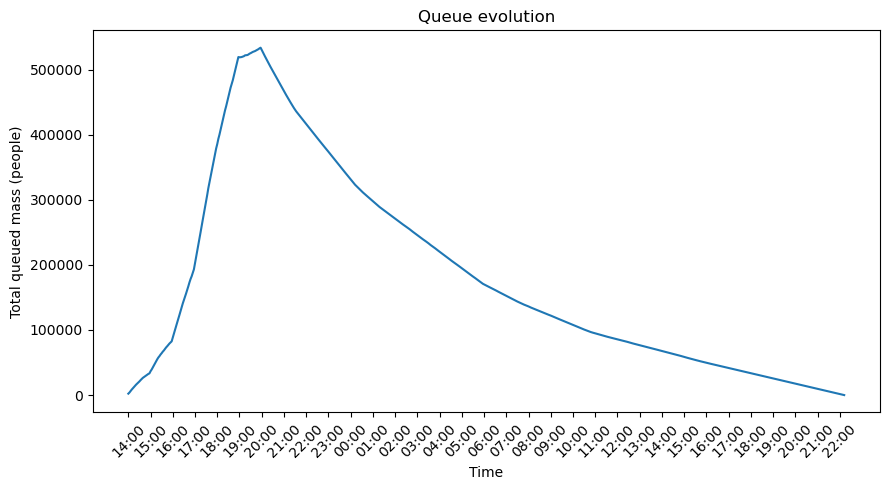

In [52]:
def tick_to_hhs(tick, start_hour=14):
    total_minutes = start_hour * 60 + tick * model.tick_seconds / 60
    h = int(total_minutes // 60) % 24   
    m = int(total_minutes % 60)
    return f"{h:02d}:{m:02d}"


labels = [tick_to_hhs(t) for t in df["tick"]]

plt.figure(figsize=(9,5))
plt.plot(df["tick"], df["total_queued"])
plt.xticks(df["tick"][::20], labels[::20], rotation=45)
plt.xlabel("Time")
plt.ylabel("Total queued mass (people)")
plt.title("Queue evolution")
plt.tight_layout()
plt.show()


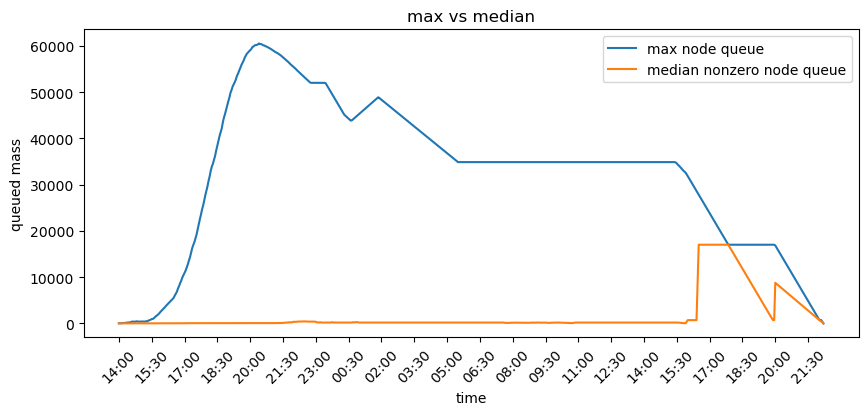

In [53]:
plt.figure(figsize=(10, 4))
plt.plot(df["tick"], df["max_node_queue"], label="max node queue")
plt.plot(df["tick"], df["median_nonzero_queue"], label="median nonzero node queue")
plt.xticks(df["tick"][::30], labels[::30], rotation=45)
plt.xlabel("time")
plt.ylabel("queued mass")
plt.legend()
plt.title("max vs median")
plt.show()


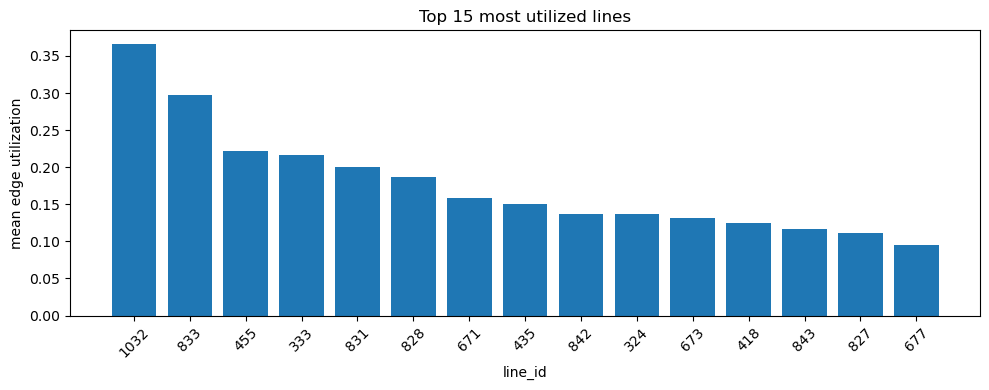

In [54]:
T = max(len(df), 1)

line_edge_utils = defaultdict(list)

for (u, v), flow in model.edge_flow_sum.items():
    data = model.H.get_edge_data(u, v, default={})
    line_id = data.get("line_id", None)
    if line_id is None:
        continue

    cap = float(data.get(model.cap_attr, np.inf))
    if not np.isfinite(cap) or cap <= 0:
        continue

    ubar_e = float(flow) / (cap * T)
    line_edge_utils[line_id].append(ubar_e)

# mean utilization per line
line_util = {
    line: float(np.mean(utils))
    for line, utils in line_edge_utils.items()
    if len(utils) > 0
}

K = 15
top_lines = sorted(line_util.items(), key=lambda x: x[1], reverse=True)[:K]

line_ids = [str(l) for l, _ in top_lines]
line_vals = np.array([v for _, v in top_lines], dtype=float)

plt.figure(figsize=(10, 4))

plt.bar(line_ids, line_vals)
plt.xlabel("line_id")
plt.ylabel("mean edge utilization")
plt.title("Top 15 most utilized lines")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [55]:
# node_queue_max[n] = max queue mass ever observed at node n
bottleneck_node, bottleneck_q = max(
    model.node_queue_max.items(),
    key=lambda kv: kv[1]
)

print("Biggest bottleneck station:")
print("Node:", bottleneck_node)
print("Max queued mass:", bottleneck_q)



Biggest bottleneck station:
Node: Shinagawa
Max queued mass: 60534.28571428575


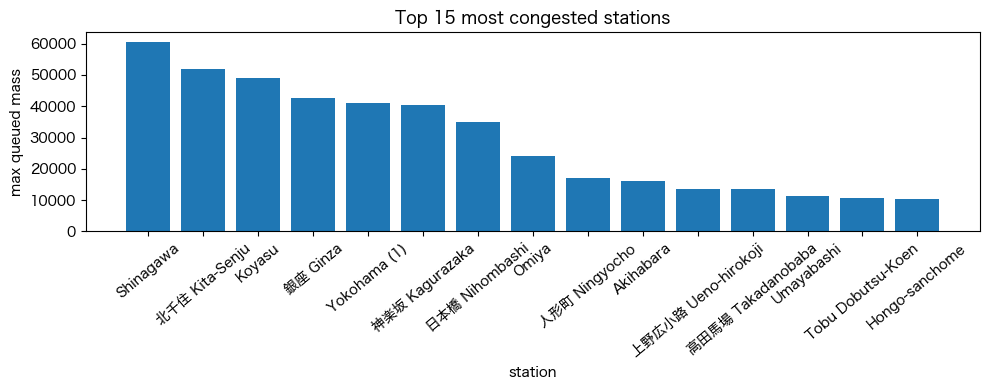

In [56]:
from matplotlib import font_manager, rcParams

font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"  # Hiragino (Japanese)
font_prop = font_manager.FontProperties(fname=font_path)

rcParams["font.family"] = font_prop.get_name()

top_nodes = sorted(
    model.node_queue_max.items(),
    key=lambda kv: kv[1],
    reverse=True
)[:K]

nodes = [str(n) for n, _ in top_nodes]
vals  = np.array([v for _, v in top_nodes], dtype=float)

plt.figure(figsize=(10, 4))

plt.bar(nodes, vals)
plt.xlabel("station")
plt.ylabel("max queued mass")
plt.title("Top 15 most congested stations")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()


In [57]:
G_lcc.edges(data=True)

EdgeDataView([('稲荷町 Inaricho', '上野 Ueno', {'line_id': 324, 'dist_km': 0.58122605030067, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('稲荷町 Inaricho', '田原町 Tawaramachi', {'line_id': 324, 'dist_km': 0.7316901561696695, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('稲荷町 Inaricho', 'Shitayajinjamae', {'line_id': 828, 'dist_km': 0.10372219683062127, 'mode': 'light_rail', 'cap_ppl_per_tick': 192.85714285714283}), ('稲荷町 Inaricho', 'Matsugaya-itchome', {'line_id': 828, 'dist_km': 0.17562824836139918, 'mode': 'light_rail', 'cap_ppl_per_tick': 192.85714285714283}), ('田原町 Tawaramachi', '浅草 Asakusa', {'line_id': 324, 'dist_km': 0.6658930421347228, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('浅草 Asakusa', '本所吾妻橋 Honjo-Azumabashi', {'line_id': 333, 'dist_km': 0.7194761962208415, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('浅草 Asakusa', '蔵前 Kuramae', {'line_id': 333, 'dist_km': 0.7973502642696846, 'mode': 'heavy_rail', 'cap_ppl_per_tick': 400.0}), ('浅草 Asakusa', 'Kaminarim

In [58]:
df = model.datacollector.get_model_vars_dataframe()

# expand dict column into a DataFrame (ticks x line_id)
L = pd.DataFrame(df["line_queue_mass"].tolist()).fillna(0.0)

top15 = L.mean(axis=0).sort_values(ascending=False).head(15)
top15

324     48787.203488
326     44868.468882
423     44400.790255
333     40069.711628
327     39417.347951
418     29485.922481
3000    29368.316279
641     29365.554374
454     27221.556146
664     25782.128018
417     24350.334468
1032    20207.749723
537     19581.751938
325     19274.980759
534     18388.978959
dtype: float64

In [103]:
for u, v, data in G_lcc.edges(data=True):
    if data.get("mode") == "heavy_rail":
        data["cap_ppl_per_tick"] = heavy_rail_capacity_per_tick
    elif data.get("mode") == "commuter_rail":
        data["cap_ppl_per_tick"] = commuter_rail_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = light_rail_capacity_per_tick
    elif data.get("mode") == "default":
        data["cap_ppl_per_tick"] = default_mode_capacity_per_tick
    elif data.get("mode") == "people_mover":
        data["cap_ppl_per_tick"] = people_mover_capacity_per_tick
    elif data.get("mode") == "light_rail":
        data["cap_ppl_per_tick"] = high_speed_rail_capacity_per_tick
    elif data.get("mode") == "tram":
        data["cap_ppl_per_tick"] = tram_capacity_per_tick

In [97]:
lines_at_shinagawa = {
    data["line_id"]
    for u, v, data in G_lcc.edges("新橋 Shimbashi", data=True)
    if "line_id" in data
}

print(lines_at_shinagawa)


{417, 324, 454, 649, 537, 638}


In [98]:
def k_closest_by_graph_distance(G, source, k, weight=None, include_source=True):
    # shortest path lengths from source
    lengths = nx.single_source_dijkstra_path_length(G, source, weight=weight) if weight else \
              nx.single_source_shortest_path_length(G, source)

    items = sorted(lengths.items(), key=lambda kv: kv[1])  # (node, dist)
    if not include_source:
        items = [(n, d) for n, d in items if n != source]

    chosen = [source] if include_source else []
    chosen += [n for n, _ in items[: max(0, k - len(chosen))]]

    return G.subgraph(chosen).copy(), chosen

In [99]:
H_k, nodes_k = k_closest_by_graph_distance(G_lcc, "Shinagawa", k=400, weight="dist_km")


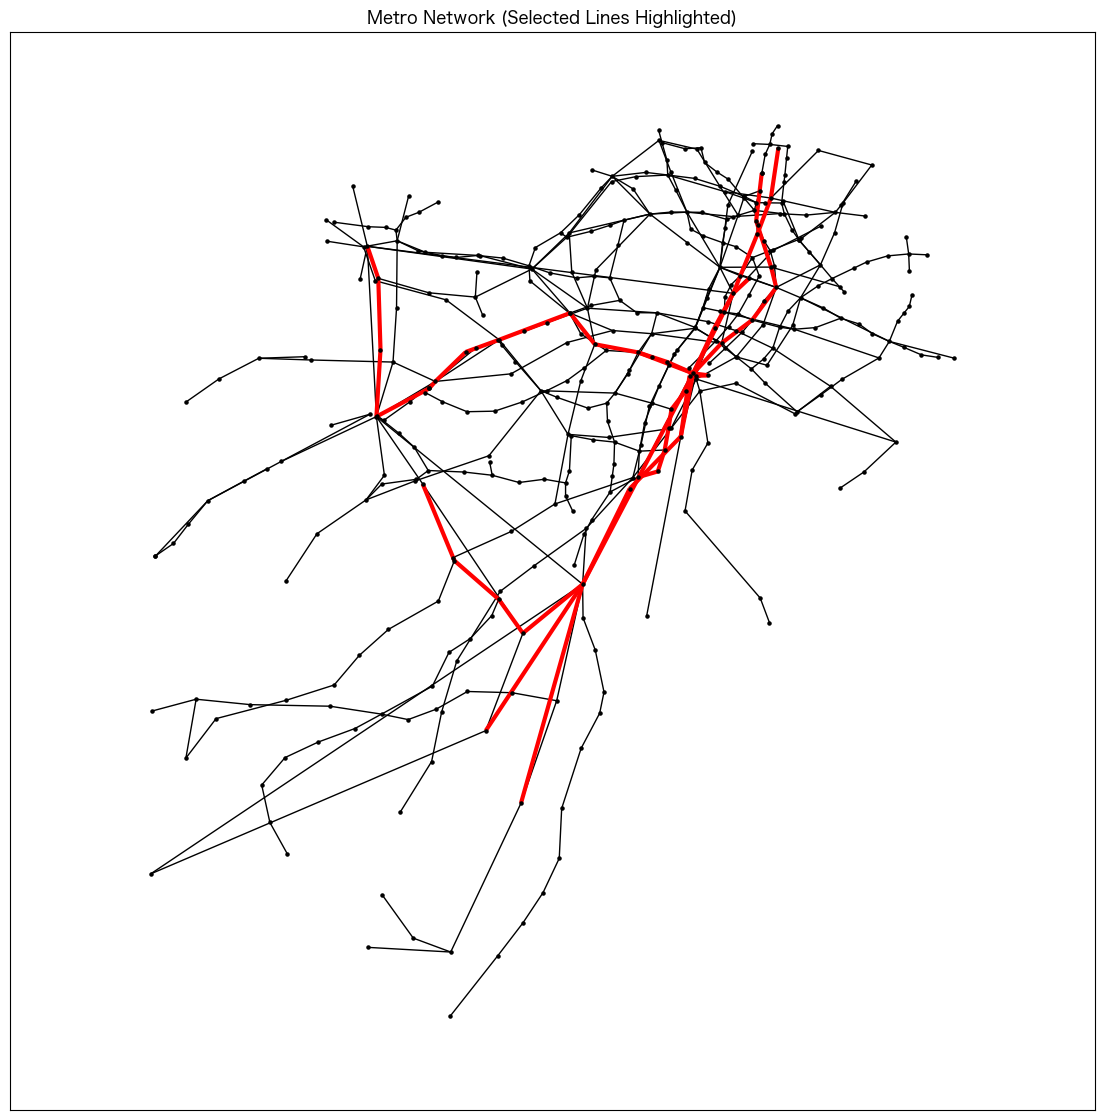

In [100]:
highlight_lines = lines_at_shinagawa

plt.figure(figsize=(14, 14))
pos = {n: H_k.nodes[n]["pos"] for n in H_k.nodes}

nx.draw_networkx_nodes(
    H_k, pos,
    node_size=5,
    node_color="black",
)

# all edges black
nx.draw_networkx_edges(
    H_k, pos,
    edge_color="black",
    width=1,
)

# overlay highlighted lines
edges_highlight = [
    (u, v) for u, v, d in H_k.edges(data=True)
    if d.get("line_id") in highlight_lines
]

nx.draw_networkx_edges(
    H_k, pos,
    edgelist=edges_highlight,
    edge_color="red",
    width=3,
)

plt.axis("equal")
plt.title("Metro Network (Selected Lines Highlighted)")
plt.show()


In [104]:
for u, v, data in G_lcc.edges(data=True):
    if data.get("line_id") == 417:
        data["cap_ppl_per_tick"] *= 6
    elif data.get("line_id") == 418:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 454:
        data["cap_ppl_per_tick"] *= 6
    elif data.get("line_id") == 423:
        data["cap_ppl_per_tick"] *= 8
    elif data.get("line_id") == 427:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 3000:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 537:
        data["cap_ppl_per_tick"] *= 6
    elif data.get("line_id") == 1032:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 324:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 649:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 638:
        data["cap_ppl_per_tick"] *= 4
    elif data.get("line_id") == 641:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 627:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 333:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 664:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 328:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 435:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 326:
        data["cap_ppl_per_tick"] *= 2
    elif data.get("line_id") == 493:
        data["cap_ppl_per_tick"] *= 2
    
    
    
    

In [105]:
caps = [
    d["cap_ppl_per_tick"]
    for u, v, d in G_lcc.edges(data=True)
    if d.get("line_id") == 1032
]
caps

[771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713,
 771.4285714285713]

In [106]:
model = QueueModel(
    H=G_lcc,
    entry_nodes=list(G_lcc.nodes),
    dest_nodes=destination_nodes_names,
    schedules=schedules,
    total_target = sum(sum(sched.values()) for sched in list(schedules.values())),
    pos=pos,
    sigma_xy=0.186,
    weight='dist_km',
    tick_seconds=180,
    cohort_mass=float(20),
    cap_attr = 'cap_ppl_per_tick',
    seed = 1
)

while model.running:
    model.step()
    

df = model.datacollector.get_model_vars_dataframe()

KeyError: '稲荷町 Inaricho'

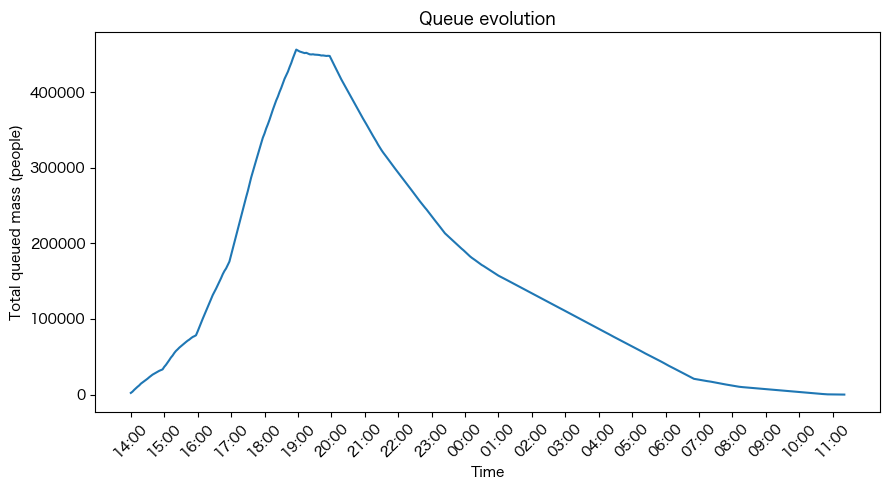

In [81]:
labels = [tick_to_hhs(t) for t in df["tick"]]

plt.figure(figsize=(9,5))
plt.plot(df["tick"], df["total_queued"])
plt.xticks(df["tick"][::20], labels[::20], rotation=45)
plt.xlabel("Time")
plt.ylabel("Total queued mass (people)")
plt.title("Queue evolution")
plt.tight_layout()
plt.show()


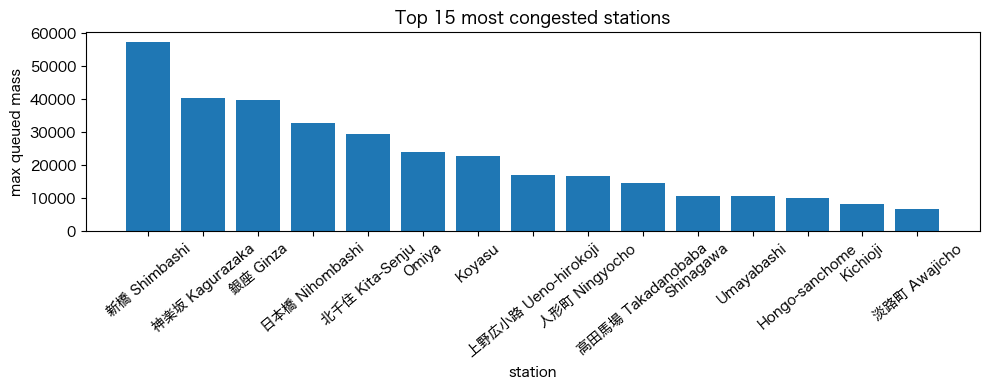

In [82]:
from matplotlib import font_manager, rcParams

font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"  # Hiragino (Japanese)
font_prop = font_manager.FontProperties(fname=font_path)

rcParams["font.family"] = font_prop.get_name()

top_nodes = sorted(
    model.node_queue_max.items(),
    key=lambda kv: kv[1],
    reverse=True
)[:K]

nodes = [str(n) for n, _ in top_nodes]
vals  = np.array([v for _, v in top_nodes], dtype=float)

plt.figure(figsize=(10, 4))

plt.bar(nodes, vals)
plt.xlabel("station")
plt.ylabel("max queued mass")
plt.title("Top 15 most congested stations")
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()